In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [2]:
# Smaller data frame of 50,000 rows
df = pd.read_csv('sampled_data_50k.csv')
# Selecting the columns we need
columns_to_select = ['action_taken', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'preapproval', 'property_value',
                     'loan_purpose', 'lien_status', 'reverse_mortgage', 'open-end_line_of_credit', 'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio',
                     'loan_term', 'negative_amortization', 'occupancy_type', 'income', 'debt_to_income_ratio', 'derived_race', 'applicant_sex', 'applicant_age_above_62']
df = df[columns_to_select]

In [3]:
print(df.shape)
df.describe()

(50000, 21)


,action_taken,preapproval,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,loan_amount,negative_amortization,occupancy_type,income,applicant_sex
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,43623.000000,50000.000000
mean,2.543580,1.974780,13.799820,1.12194,30.962920,30.733740,30.868660,2.768338e+05,31.232500,1.149340,131.903400,1.702080
std,1.893466,0.156794,14.751788,0.32722,176.879255,176.569028,176.686037,1.656608e+06,177.667544,0.500243,1363.958807,0.964999
min,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,5.000000e+03,1.000000,1.000000,-6291.000000,1.000000
25%,1.000000,2.000000,1.000000,1.00000,2.000000,2.000000,2.000000,1.150000e+05,2.000000,1.000000,55.000000,1.000000
50%,1.000000,2.000000,2.000000,1.00000,2.000000,2.000000,2.000000,2.050000e+05,2.000000,1.000000,86.000000,1.000000
75%,4.000000,2.000000,31.000000,1.00000,2.000000,2.000000,2.000000,3.150000e+05,2.000000,1.000000,136.000000,2.000000
max,8.000000,2.000000,32.000000,2.00000,1111.000000,1111.000000,1111.000000,2.870050e+08,1111.000000,3.000000,200002.000000,6.000000


### Looking at NA values by row.

In [4]:
# Creating a column that indicates the number of NA values for each observation
na_df = df.isnull().sum(axis=1)

# Getting the summary statistics for NA_count column
na_df.describe()

count    50000.000000
mean         1.101960
std          1.520937
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max          7.000000
dtype: float64

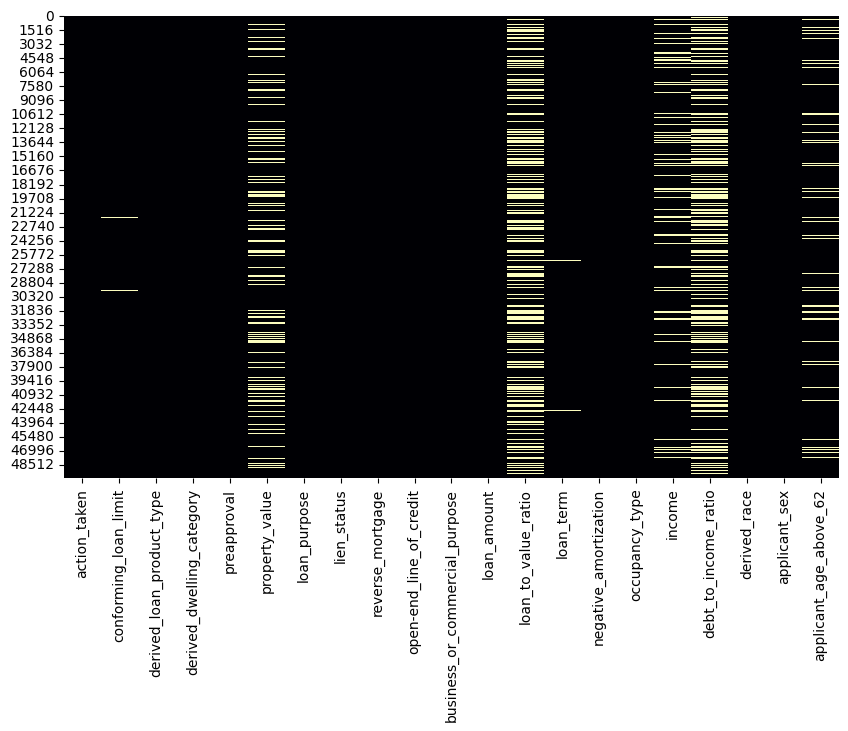

In [5]:
# Plotting a heatmap of NA values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='magma')
plt.show()

In [6]:
# Compute the percentage of NA values for each column
na_percent = df.isna().mean() * 100

# Print columns with NA values and their percentages
for column, percent in na_percent.items():
    if percent > 0:
        print(f'{column} has {percent:.2f}% NA values.')

conforming_loan_limit has 0.43% NA values.
property_value has 19.18% NA values.
loan_to_value_ratio has 33.73% NA values.
loan_term has 1.28% NA values.
income has 12.75% NA values.
debt_to_income_ratio has 33.97% NA values.
applicant_age_above_62 has 8.86% NA values.


## Using KNN to impute missing NA values

In [7]:
# KNN imputer does not work with strings.
# Finding which columns are object data types
string_columns = df.select_dtypes(include=['object']).columns
print(string_columns)

Index(['conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category', 'property_value', 'loan_to_value_ratio',
       'loan_term', 'debt_to_income_ratio', 'derived_race',
       'applicant_age_above_62'],
      dtype='object')


In [8]:
# Some columns are being stored as strings because they have an 'exempt' value.

# Finding columns with exempt
columns_with_exempt = []

# Iterate through all columns
for col in df.columns:
    # Check if 'Exempt' is in the column
    if (df[col] == 'Exempt').any():
        columns_with_exempt.append(col)


columns_with_exempt

['property_value', 'loan_to_value_ratio', 'loan_term', 'debt_to_income_ratio']

In [9]:
# Replacing the word 'Exempt" with NA values and changing the column to numeric

# Iterate through the specified columns
for col in columns_with_exempt:
    # Replace the word 'Exempt' with NA
    df[col] = df[col].replace('Exempt', np.nan)
    
    # Convert the column to a numeric data type
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [10]:
# Finding columns that are both strings and have NA values
string_columns_with_na = [col for col in df.columns if df[col].dtype == 'object' and df[col].isna().any()]

# Print the names of these columns
print(string_columns_with_na)

['conforming_loan_limit', 'applicant_age_above_62']


In [11]:
# KNN imputer cannot use string columns, so separating and saving the string columns
# Separate string columns
string_df = df.select_dtypes(include=['object'])

# Begin KNN imputation on numeric columns
KNN_imputer = KNNImputer(n_neighbors=4)
numeric_df = df.select_dtypes(include=[np.number])
numeric_df_imputed = pd.DataFrame(KNN_imputer.fit_transform(numeric_df), columns=numeric_df.columns, index=numeric_df.index)

In [12]:
# Looking at the new data frame which should have no NA values
print("Number of NA values:", numeric_df_imputed.isna().sum().sum())

Number of NA values: 0


In [13]:
# Combine the imputed numeric columns with the original string columns
combined_df = pd.concat([numeric_df_imputed, string_df], axis=1)

In [14]:
# Finding columns that are both strings and have NA values
string_columns_with_na = [col for col in combined_df.columns if combined_df[col].dtype == 'object' and combined_df[col].isna().any()]

# Print the names of these columns
print(string_columns_with_na)

['conforming_loan_limit', 'applicant_age_above_62']


In [15]:
# Imputing mode for remaining categorical variables
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
combined_df_imputed = pd.DataFrame(imputer.fit_transform(combined_df), columns=combined_df.columns)

In [16]:
# Checking to see if any NA values remain
print("Number of NA values:", combined_df_imputed.isna().sum().sum())

Number of NA values: 0


### Cleaning up features and saving the file

In [17]:
# Replace 'Joint' and 'Free Form Text Only' with '2 or more minority races' in 'derived_race'
combined_df_imputed['derived_race'] = combined_df_imputed['derived_race'].replace(['Joint', 'Free Form Text Only'], '2 or more minority races')

# Changing the sex categories to make it more interpretable
combined_df_imputed['applicant_sex'] = combined_df_imputed['applicant_sex'].astype(float).astype(int)

# Transform values that aren't 1 or 2 to 3
combined_df_imputed['applicant_sex'] = combined_df_imputed['applicant_sex'].apply(lambda x: x if x in [1, 2] else 3)

# Map the integer values to their corresponding string representation
gender_mapping = {
    1: 'Male',
    2: 'Female',
    3: 'Other'
}
combined_df_imputed['applicant_sex'] = combined_df_imputed['applicant_sex'].map(gender_mapping)

# Converting target variable to binary
combined_df_imputed['action_taken'] = combined_df_imputed['action_taken'].apply(lambda x: 1 if x in [1,2,6] else 0)

In [18]:
# Saving the data set
combined_df_imputed.to_csv('na_filled_df.csv', index=False)